In [1]:
import pickle
from distutils.dir_util import copy_tree
from IPython.display import clear_output
import numpy as np
import pandas as pd

main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/"

def readpkl(main_path, outdir,upper_limit_zero):
    file_path = f"{main_path}{outdir}/result_dictionary.pkl"
    category_labels=["state"]
    # Check if the file exists
    with open(file_path, "rb") as f:
        simulation_results = pickle.load(f)
        print("File loaded successfully.")
        
    target_zero_inflations=list()
    for sim in simulation_results.keys():
        sublist=str.split(sim,"_")
        target_zero_inflations.append(sublist[2])
    target_zero_inflations=np.sort(np.unique(target_zero_inflations))
    runs=100
    organized_results={}

    data_frames_to_merge = []
    result_names=[]
    for target in target_zero_inflations:
        for run in range(runs):
            #print(run)
            result_name=f'zero_inflation_{target}_run_{run}'
            
            temp_df=simulation_results[result_name].copy()
            #print(temp_df.shape)
            direction=True
            temp_df["zero_inflation"]=float(target)/upper_limit_zero
            temp_df['run']=run

            data_frames_to_merge.append(temp_df)    
    organized_results=pd.concat(data_frames_to_merge)
    return organized_results

atob_outdir="realistic_simulation_alpha_to_beta"
ttoc_outdir="realistic_simulation_beta_t2d_to_control"
wheel_outdir="realistic_simulation_alpha_to_beta_custom"
atob=readpkl(main_path,atob_outdir, upper_limit_zero=0.538)
ttoc=readpkl(main_path,ttoc_outdir, upper_limit_zero=0.622)
wheel=readpkl(main_path,wheel_outdir,upper_limit_zero=0.538)


File loaded successfully.
File loaded successfully.
File loaded successfully.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gene_auc_with_ci(dataframe, label_col, score_col, zero_col, percentile=95, max_unique_colors=10, colormap='tab10'):
    """
    Plots the average score versus zero inflation for each gene, highlights genes with top AUCs,
    and includes 95% confidence intervals. Top percentile genes are assigned unique colors (up to `max_unique_colors`).

    Parameters:
        dataframe (pd.DataFrame): The input data containing the columns for grouping, scores, and zero inflation.
        label_col (str): Column name for labels (e.g., gene identifiers).
        score_col (str): Column name for scores (e.g., centrality measure).
        zero_col (str): Column name for zero inflation values.
        percentile (float): Percentile threshold to highlight top AUC genes. Default is 98.
        max_unique_colors (int): Maximum number of unique colors for top genes. Default is 10.
        colormap (str): Name of the colormap to use from plt.colormaps.
    """
    # Group by label and zero inflation, calculate the mean score and standard error
    grouped = dataframe.groupby([label_col, zero_col])
    mean_scores = grouped[score_col].mean().reset_index()
    sem_scores = grouped[score_col].sem().reset_index()  # Standard error of the mean

    # Merge mean and standard error for easy plotting
    merged = mean_scores.merge(sem_scores, on=[label_col, zero_col], suffixes=('_mean', '_sem'))
    merged[zero_col] = merged[zero_col].astype(float)
    # Compute the area under the curve (AUC) for each label
    auc_values = {}
    aucs=[]
    auc_labels=[]
    for label in merged[label_col].unique():
        label_data = merged[merged[label_col] == label]
        auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Calculate AUC using trapezoidal rule
        auc_values[label] = auc
        aucs.append(auc)
        auc_labels.append(label)
    
    # Determine the specified percentile of AUC
    auc_percentile_threshold = np.percentile(list(auc_values.values()), percentile)

    # Get top genes based on AUC
    top_genes = sorted(auc_values.items(), key=lambda x: x[1], reverse=True)[:max_unique_colors]
    top_gene_labels = [gene for gene, _ in top_genes]

    # Create the colormap
    cmap = plt.colormaps[colormap]
    colors = [cmap(i / max_unique_colors) for i in range(max_unique_colors)]
    color_map = {gene: colors[i % max_unique_colors] for i, gene in enumerate(top_gene_labels)}

    # Initialize the plot
    plt.figure(figsize=(12, 6))

    # Plot each label's data with 95% CI
    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label not in top_gene_labels:  # Highlight top genes
            plt.plot(zero_vals, mean, marker='o', color='black', alpha=0.1,linestyle='dashed')

    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label in top_gene_labels:  # Highlight top genes        
            color = color_map[label]
            plt.plot(zero_vals, mean, marker='o', label=f"{label} (AUC: {auc:.2f})", color=color)
            plt.fill_between(zero_vals, ci_lower, ci_upper, color=color, alpha=0.1)
            
    # Add labels, legend, and grid
    plt.title("Average Score vs Zero Inflation for Each Label (with 95% CI)")
    plt.xlabel(zero_col)
    plt.ylabel("Average " + score_col)
    plt.legend(title="Label", loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    to_return=pd.DataFrame({'auc':aucs,'genes':auc_labels})
    
    return to_return

/tmp/ipykernel_35301/1444882521.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Calculate AUC using trapezoidal rule


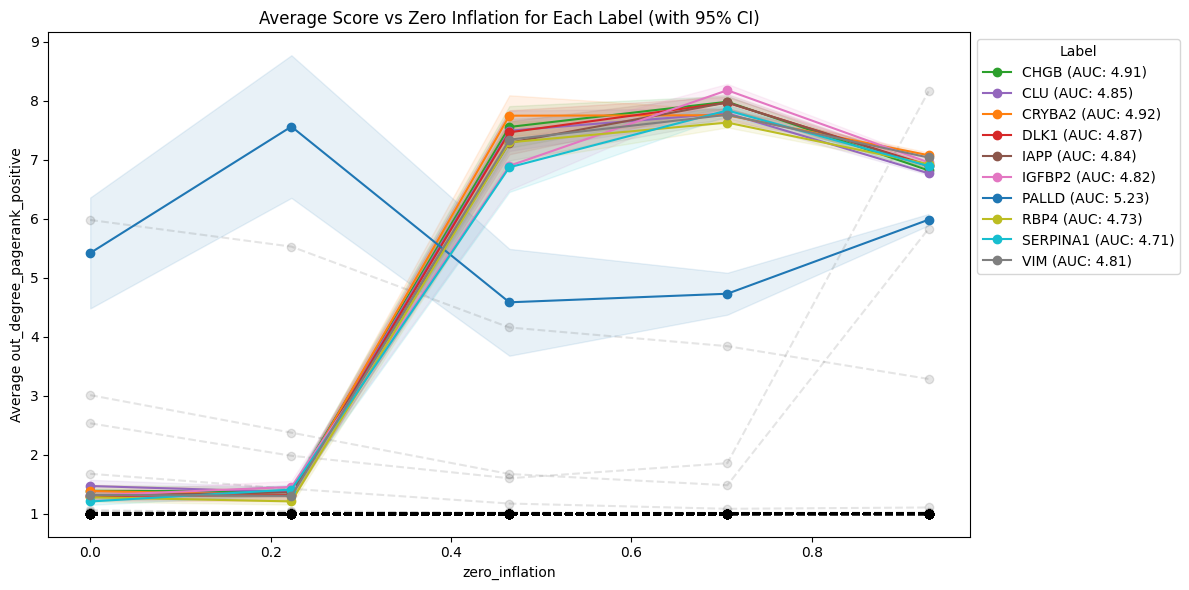

In [3]:
odp=plot_gene_auc_with_ci(
    dataframe=wheel,
    label_col='label',
    score_col='out_degree_pagerank_positive',
    zero_col='zero_inflation', max_unique_colors=10, colormap='tab20'
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd



def plot_gene_auc_with_ci(dataframe, label_col, score_col, zero_col, percentile=95, max_unique_colors=10, colormap='tab10', ax=None):
    """
    Plots the average score versus zero inflation for each gene, highlights genes with top AUCs,
    and includes 95% confidence intervals. Top percentile genes are assigned unique colors (up to `max_unique_colors`).
    
    If an `ax` is provided, the plot is drawn on that axis; otherwise, a new figure is created.
    
    Parameters:
        dataframe (pd.DataFrame): The input data containing the columns for grouping, scores, and zero inflation.
        label_col (str): Column name for labels (e.g., gene identifiers).
        score_col (str): Column name for scores (e.g., centrality measure).
        zero_col (str): Column name for zero inflation values.
        percentile (float): Percentile threshold to highlight top AUC genes. Default is 95.
        max_unique_colors (int): Maximum number of unique colors for top genes. Default is 10.
        colormap (str): Name of the colormap to use from plt.colormaps.
        ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis to plot on (for multi-plot support).

    Returns:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis containing the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Group by label and zero inflation, calculate the mean score and standard error
    grouped = dataframe.groupby([label_col, zero_col])
    mean_scores = grouped[score_col].mean().reset_index()
    sem_scores = grouped[score_col].sem().reset_index()  # Standard error of the mean

    # Merge mean and standard error for easy plotting
    merged = mean_scores.merge(sem_scores, on=[label_col, zero_col], suffixes=('_mean', '_sem'))
    merged[zero_col] = merged[zero_col].astype(float)
    # Compute the area under the curve (AUC) for each label
    auc_values = {}
    for label in merged[label_col].unique():
        label_data = merged[merged[label_col] == label]
        auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Trapezoidal rule
        auc_values[label] = auc
    
    # Get top genes based on AUC
    top_genes = sorted(auc_values.items(), key=lambda x: x[1], reverse=True)[:max_unique_colors]
    top_gene_labels = [gene for gene, _ in top_genes]

    # Create the colormap
    cmap = plt.colormaps[colormap]
    colors = [cmap(i / max_unique_colors) for i in range(max_unique_colors)]
    color_map = {gene: colors[i % max_unique_colors] for i, gene in enumerate(top_gene_labels)}

    # Plot each label's data with 95% CI
    for label in auc_values.keys():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label not in top_gene_labels:  # Highlight top genes with color
            ax.plot(zero_vals, mean, marker='o', color='grey', alpha=0.1, linestyle='dashed')
    for label in auc_values.keys():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label in top_gene_labels:  # Highlight top genes with color
            color = color_map[label]
            ax.plot(zero_vals, mean, marker='o', label=f"{label}", color=color)
            ax.fill_between(zero_vals, ci_lower, ci_upper, color=color, alpha=0.1)
            
    # Add labels, legend, and grid
    ax.legend(title="Top 10 genes", loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(False)

    return ax


/tmp/ipykernel_35301/1820274669.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Trapezoidal rule
/tmp/ipykernel_35301/1820274669.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Trapezoidal rule
/tmp/ipykernel_35301/1820274669.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Trapezoidal rule
/tmp/ipykernel_35301/1820274669.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(label_d

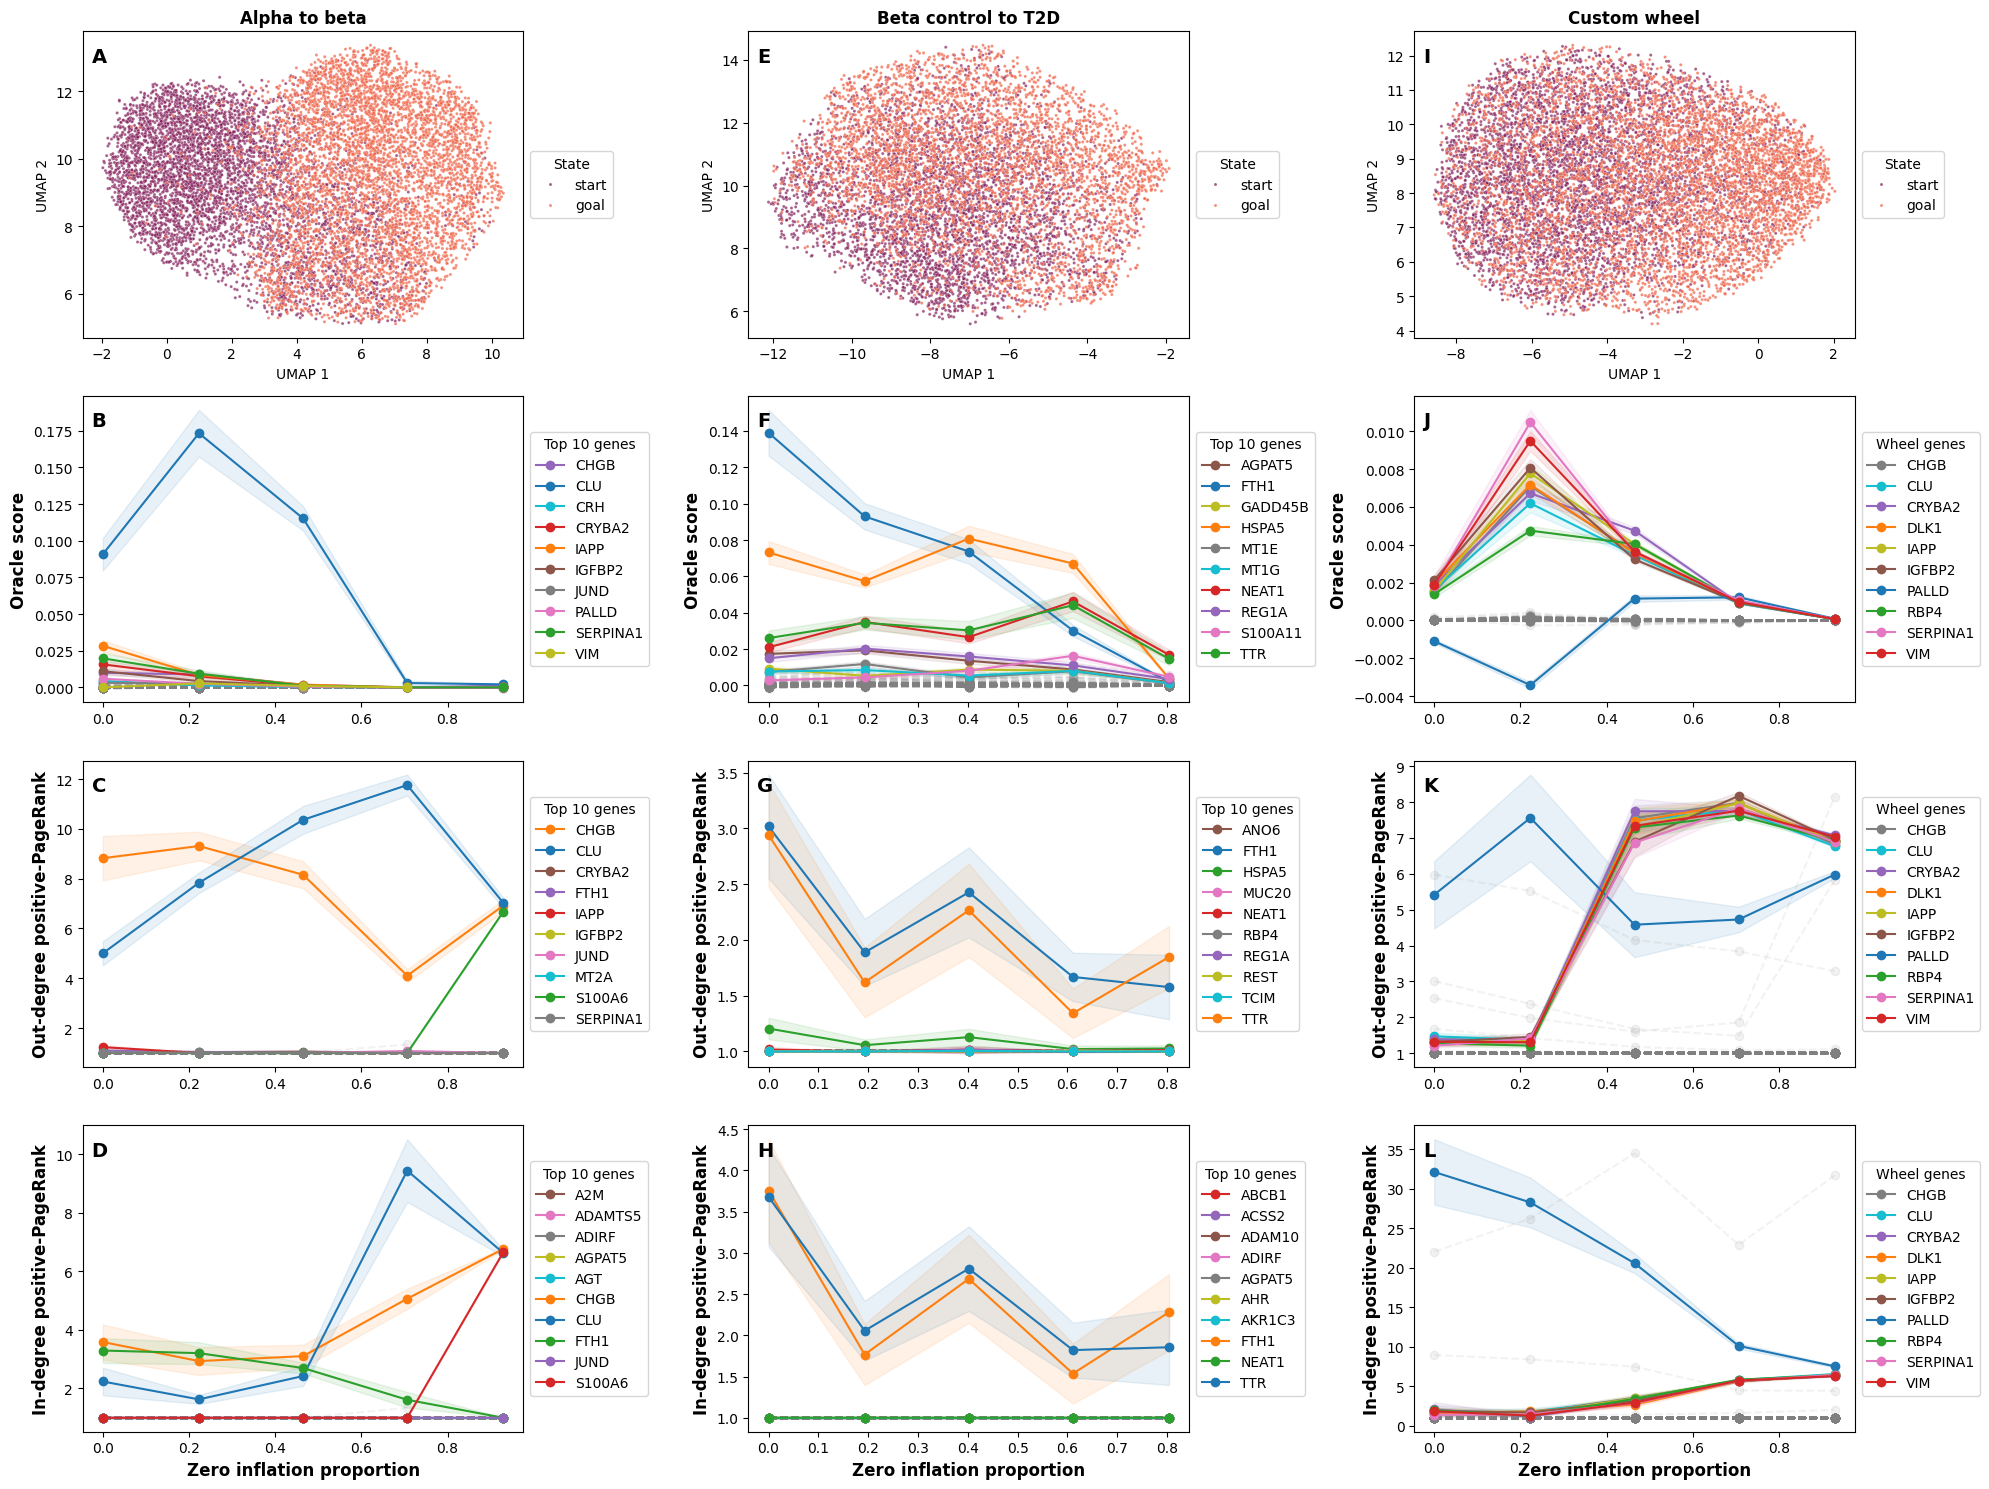

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gene_auc_with_ci_custom(dataframe, label_col, score_col, zero_col,tocolor, percentile=98, max_unique_colors=10, colormap='tab10',ax=None):
    """
    Plots the average score versus zero inflation for each gene, highlights genes with top AUCs,
    and includes 95% confidence intervals. Top percentile genes are assigned unique colors (up to `max_unique_colors`).

    Parameters:
        dataframe (pd.DataFrame): The input data containing the columns for grouping, scores, and zero inflation.
        label_col (str): Column name for labels (e.g., gene identifiers).
        score_col (str): Column name for scores (e.g., centrality measure).
        zero_col (str): Column name for zero inflation values.
        percentile (float): Percentile threshold to highlight top AUC genes. Default is 98.
        max_unique_colors (int): Maximum number of unique colors for top genes. Default is 10.
        colormap (str): Name of the colormap to use from plt.colormaps.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    # Group by label and zero inflation, calculate the mean score and standard error
    grouped = dataframe.groupby([label_col, zero_col])
    mean_scores = grouped[score_col].mean().reset_index()
    sem_scores = grouped[score_col].sem().reset_index()  # Standard error of the mean

    # Merge mean and standard error for easy plotting
    merged = mean_scores.merge(sem_scores, on=[label_col, zero_col], suffixes=('_mean', '_sem'))
    merged[zero_col] = merged[zero_col].astype(float)
    # Compute the area under the curve (AUC) for each label
    auc_values = {}
    for label in merged[label_col].unique():
        label_data = merged[merged[label_col] == label]
        auc = np.trapz(label_data[f"{score_col}_mean"], label_data[zero_col])  # Calculate AUC using trapezoidal rule
        auc_values[label] = auc

    # Determine the specified percentile of AUC
    auc_percentile_threshold = np.percentile(list(auc_values.values()), percentile)

    # Get top genes based on AUC
    top_genes = tocolor#sorted(auc_values.items(), key=lambda x: x[1], reverse=True)[:max_unique_colors]
    top_gene_labels = tocolor#[gene for gene, _ in top_genes]
    
    # Create the colormap
    cmap = plt.colormaps[colormap]
    colors = [cmap(i / max_unique_colors) for i in range(max_unique_colors)]
    color_map = {gene: colors[i % max_unique_colors] for i, gene in enumerate(top_gene_labels)}


    # Plot each label's data with 95% CI
    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]

        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label not in top_gene_labels:  # Highlight top genes
            ax.plot(zero_vals, mean, marker='o', color='grey', alpha=0.1,linestyle='dashed')

    for label, auc in auc_values.items():
        label_data = merged[merged[label_col] == label]
        mean = label_data[f"{score_col}_mean"]
        sem = label_data[f"{score_col}_sem"]
        zero_vals = label_data[zero_col]
        ci_upper = mean + 1.96 * sem  # 95% CI upper bound
        ci_lower = mean - 1.96 * sem  # 95% CI lower bound

        if label in top_gene_labels:  # Highlight top genes
            color = color_map[label]
            ax.plot(zero_vals, mean, marker='o', label=f"{label}", color=color)
            ax.fill_between(zero_vals, ci_lower, ci_upper, color=color, alpha=0.1)
    # Add labels, legend, and grid
    #ax.set_title("Score vs Zero Inflation")
    #ax.set_xlabel(zero_col)
    #ax.set_ylabel("Average " + score_col)
    #ax.legend(title="Top 10 genes", loc='upper left', fontsize=8)
    ax.legend(title="Wheel genes",loc='center left', bbox_to_anchor=(1, 0.5))

    ax.grid(False)

    return ax



def plot_umap(df, x_col, y_col, color_col, ax,title=""):
    """
    Plots a UMAP scatter plot colored by the given categorical variable.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        x_col (str): Column name for UMAP x-coordinates.
        y_col (str): Column name for UMAP y-coordinates.
        color_col (str): Column name for categorical coloring.
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
    """
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=color_col, alpha=0.7,s=5, ax=ax, palette="rocket")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.legend(title="State", loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=12, fontweight="bold")


def assemble_multiplot(dataframes, umap_data, score_columns, label_col, zero_col, 
                        dataset_names=None, score_titles=None, x_axis_label=None):
    """
    Creates a 3x4 multi-plot where:
      - The first COLUMN contains UMAP visualizations for each dataset.
      - The next 3 COLUMNS contain score-based gene AUC plots.
      - Each ROW represents a dataset.
      - Shared Y-label per row (dataset name).
      - Shared X-label (custom, bottom row).
      - Independent Y-scales for AUC plots.
      - Labels A-L for each subplot.

    Parameters:
        dataframes (list of pd.DataFrame): List of 3 dataframes for AUC plots.
        umap_data (list of pd.DataFrame): List of 3 dataframes for UMAP plots.
        score_columns (list of str): List of 3 unique score columns.
        label_col (str): Column name for gene labels.
        zero_col (str): Column name for zero inflation.
        dataset_names (list of str, optional): Custom dataset names (row labels).
        score_titles (list of str, optional): Custom score type titles (column titles).
        x_axis_label (str, optional): Custom shared X-axis label.

    Returns:
        fig (matplotlib.figure.Figure): The figure containing all plots.
    """
    num_rows, num_cols = 4,3  # Adding UMAP column
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharex=False, sharey=False)  
    axes = axes.flatten()  # Convert 2D array into 1D for easy indexing
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_rows)]  # Default row labels
    if score_titles is None:
        score_titles = score_columns  # Default column titles
    if x_axis_label is None:
        x_axis_label = zero_col  # Default X-axis label

    subplot_labels = ["A", "E", "I", "B", "F", "J", "C", "G", "K", "D", "H", "L"] 
    # A-L labels
    custom_labels=np.array(['PALLD','DLK1','RBP4','VIM','CRYBA2','IGFBP2','SERPINA1','CHGB','IAPP','CLU'])
    plot_umap(umap_data[0], "umap1", "umap2", "state", ax=axes[0],title=dataset_names[0])
    plot_umap(umap_data[1], "umap1", "umap2", "state", ax=axes[1],title=dataset_names[1])
    plot_umap(umap_data[2], "umap1", "umap2", "state", ax=axes[2],title=dataset_names[2])

    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[0], zero_col, ax=axes[3])
    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[1], zero_col, ax=axes[6])
    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[2], zero_col, ax=axes[9])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[0], zero_col, ax=axes[4])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[1], zero_col, ax=axes[7])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[2], zero_col, ax=axes[10])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[0], zero_col,tocolor=custom_labels, ax=axes[5])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[1], zero_col,tocolor=custom_labels, ax=axes[8])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[2], zero_col,tocolor=custom_labels, ax=axes[11])


    axes[3].set_ylabel(score_titles[0], fontsize=12, fontweight="bold")
    axes[4].set_ylabel(score_titles[0], fontsize=12, fontweight="bold")
    axes[5].set_ylabel(score_titles[0], fontsize=12, fontweight="bold")
    axes[6].set_ylabel(score_titles[1], fontsize=12, fontweight="bold")
    axes[7].set_ylabel(score_titles[1], fontsize=12, fontweight="bold")
    axes[8].set_ylabel(score_titles[1], fontsize=12, fontweight="bold")
    axes[9].set_ylabel(score_titles[2], fontsize=12, fontweight="bold")
    axes[10].set_ylabel(score_titles[2], fontsize=12, fontweight="bold")
    axes[11].set_ylabel(score_titles[2], fontsize=12, fontweight="bold")
    axes[9].set_xlabel(x_axis_label, fontsize=12, fontweight="bold")
    axes[10].set_xlabel(x_axis_label, fontsize=12, fontweight="bold")
    axes[11].set_xlabel(x_axis_label, fontsize=12, fontweight="bold")





    axes[0].text(0.02, 0.95, subplot_labels[0], transform=axes[0].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[1].text(0.02, 0.95, subplot_labels[1], transform=axes[1].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[2].text(0.02, 0.95, subplot_labels[2], transform=axes[2].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[3].text(0.02, 0.95, subplot_labels[3], transform=axes[3].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[4].text(0.02, 0.95, subplot_labels[4], transform=axes[4].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[5].text(0.02, 0.95, subplot_labels[5], transform=axes[5].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[6].text(0.02, 0.95, subplot_labels[6], transform=axes[6].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[7].text(0.02, 0.95, subplot_labels[7], transform=axes[7].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[8].text(0.02, 0.95, subplot_labels[8], transform=axes[8].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[9].text(0.02, 0.95, subplot_labels[9], transform=axes[9].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[10].text(0.02, 0.95, subplot_labels[10], transform=axes[10].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[11].text(0.02, 0.95, subplot_labels[11], transform=axes[11].transAxes,fontsize=14, fontweight="bold", va="top")  
    plt.tight_layout()
    plt.show()
    return fig

umapa2b=pd.read_csv(f"{main_path}{atob_outdir}/alphatobetaUMAP.csv")
umapwheel=pd.read_csv(f"{main_path}{wheel_outdir}/customalphatobetaUMAP.csv")
umapttoc=pd.read_csv(f"{main_path}{ttoc_outdir}/t2dtocontrolUMAP.csv")
# Example usage with three dataframes and three score columns
dataframes = [atob, ttoc, wheel]  # Replace with actual DataFrames
score_columns = ['oracle_score', 'out_degree_pagerank_positive','in_degree_pagerank_positive']  # Replace with actual column names

fig = assemble_multiplot(
    dataframes=dataframes, 
    umap_data=[umapa2b, umapttoc, umapwheel], 
    score_columns=score_columns,
    label_col='label',
    zero_col='zero_inflation',
    dataset_names=['Alpha to beta', 'Beta control to T2D', 'Custom wheel'],  # Custom row labels
    score_titles=['Oracle score', 'Out-degree positive-PageRank', 'In-degree positive-PageRank'],      # Custom column titles
    x_axis_label='Zero inflation proportion'  # Custom X-axis label
)

fig.savefig(main_path+'SimulationResults.png')

/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarnin

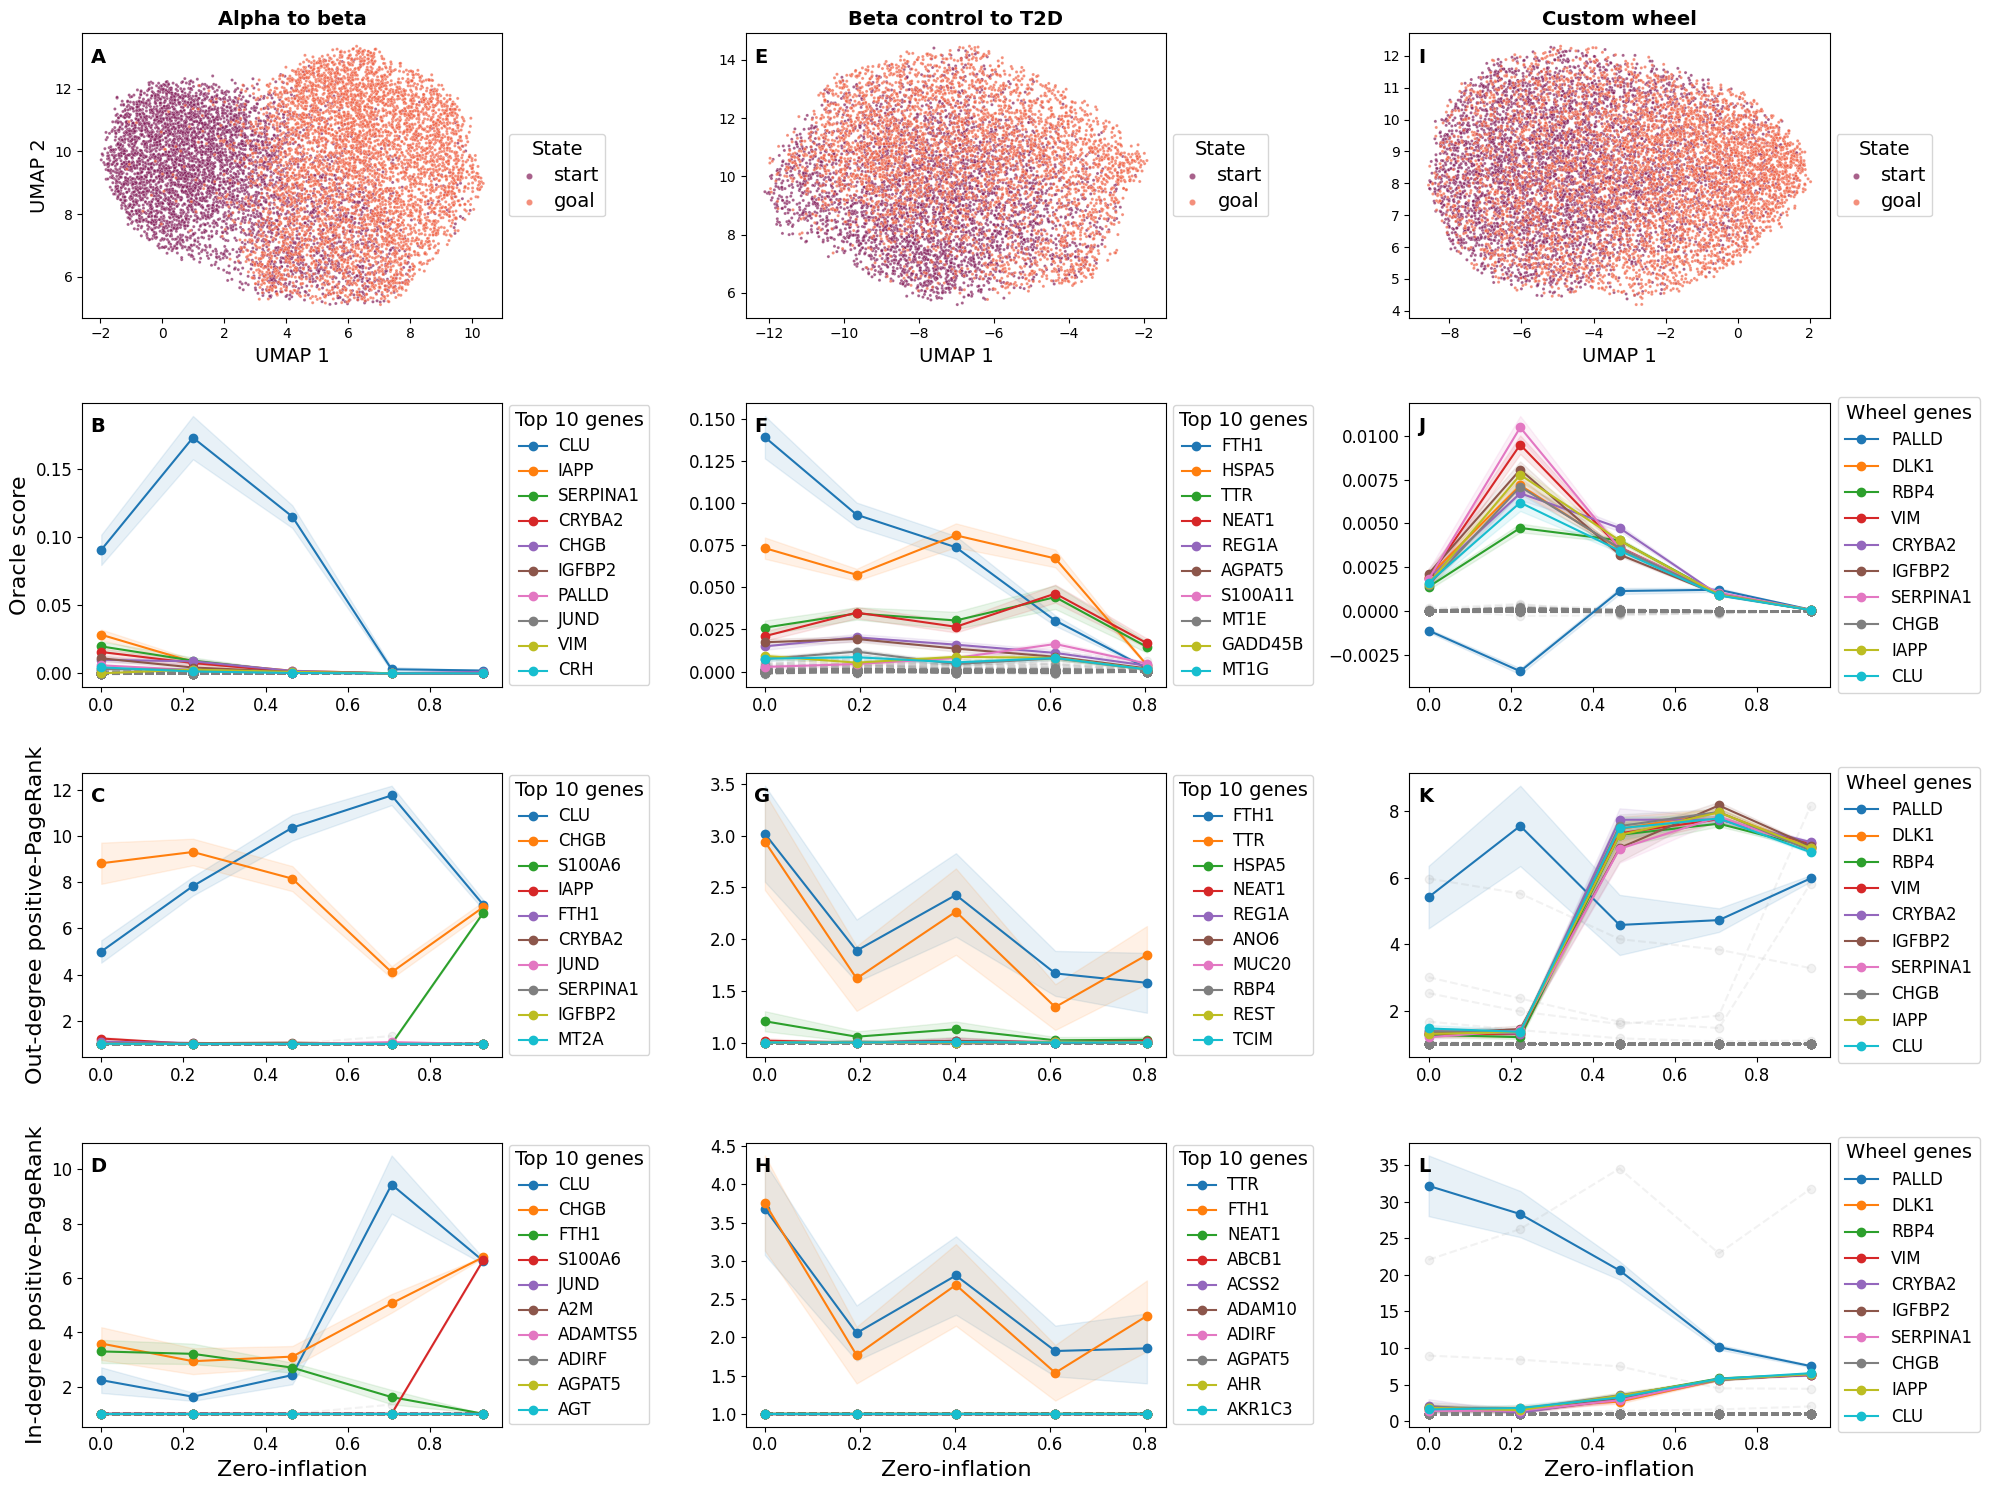

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_gene_auc_with_ci(
    dataframe,
    label_col,
    score_col,
    zero_col,
    percentile=95,
    max_unique_colors=10,
    colormap='tab10',
    ax=None
):
    """
    Plots the average score versus zero inflation for each gene, highlights genes with top AUCs,
    and includes 95% confidence intervals. Text sizes tuned for a 6×4″ figure in a 12 pt–font paper.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # ── compute means & SEMs ────────────────────────────────────────────────────
    grouped = dataframe.groupby([label_col, zero_col])
    mean_scores = grouped[score_col].mean().reset_index()
    sem_scores = grouped[score_col].sem().reset_index()
    merged = mean_scores.merge(sem_scores, on=[label_col, zero_col], suffixes=('_mean', '_sem'))
    merged[zero_col] = merged[zero_col].astype(float)

    # ── compute AUC per gene ───────────────────────────────────────────────────
    auc_values = {
        lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
        for lab, group in merged.groupby(label_col)
    }
    top = sorted(auc_values, key=lambda g: auc_values[g], reverse=True)[:max_unique_colors]

    # ── colour map ─────────────────────────────────────────────────────────────
    cmap = plt.colormaps[colormap]
    colours = [cmap(i / max_unique_colors) for i in range(max_unique_colors)]
    colour_map = {g: colours[i] for i, g in enumerate(top)}

    # ── plot non-top genes ──────────────────────────────────────────────────────
    for lab, group in merged.groupby(label_col):
        mean = group[f"{score_col}_mean"]
        sem  = group[f"{score_col}_sem"]
        xs   = group[zero_col]
        if lab not in top:
            ax.plot(xs, mean, marker='o', linestyle='dashed',
                    color='grey', alpha=0.1)

    # ── plot top genes with CI ─────────────────────────────────────────────────
    for lab in top:
        group = merged[merged[label_col] == lab]
        mean = group[f"{score_col}_mean"]
        sem  = group[f"{score_col}_sem"]
        xs   = group[zero_col]
        col  = colour_map[lab]
        ax.plot(xs, mean, marker='o', label=lab, color=col)
        ax.fill_between(xs, mean - 1.96*sem, mean + 1.96*sem, color=col, alpha=0.1)

    # ── axis labels ────────────────────────────────────────────────────────────
    ax.set_xlabel(zero_col, fontsize=14)
    ax.set_ylabel(f"Mean {score_col}", fontsize=14)

    # ── legend & grid ──────────────────────────────────────────────────────────
    leg = ax.legend(title=f"Top {len(top)} genes",
                    loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(False)

    # ── font sizing ────────────────────────────────────────────────────────────
    ax.tick_params(axis='both', labelsize=12)
    if leg:
        leg.get_title().set_fontsize(14)
        for txt in leg.get_texts():
            txt.set_fontsize(12)

    return ax

def plot_gene_auc_with_ci_custom(
    dataframe, label_col, score_col, zero_col, tocolor,
    percentile=98, max_unique_colors=10, colormap='tab10', ax=None
):
    """
    Plots the average score versus zero inflation for each gene, highlights genes with top AUCs,
    and includes 95% confidence intervals. Text sizes tuned for a 6×4″ figure in a 12 pt–font paper.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # ── compute means & SEMs ────────────────────────────────────────────────────
    grouped    = dataframe.groupby([label_col, zero_col])
    mean_scores = grouped[score_col].mean().reset_index()
    sem_scores  = grouped[score_col].sem().reset_index()
    merged      = mean_scores.merge(sem_scores, on=[label_col, zero_col], suffixes=('_mean','_sem'))
    merged[zero_col] = merged[zero_col].astype(float)

    # ── compute AUC per gene ───────────────────────────────────────────────────
    auc_values = {
        lab: np.trapz(g[f"{score_col}_mean"], g[zero_col])
        for lab, g in merged.groupby(label_col)
    }

    # ── explicit tocolor list ───────────────────────────────────────────────────
    top_gene_labels = tocolor[:max_unique_colors]

    # ── colour map ─────────────────────────────────────────────────────────────
    cmap      = plt.colormaps[colormap]
    colours   = [cmap(i/max_unique_colors) for i in range(max_unique_colors)]
    colour_map = {g: colours[i] for i,g in enumerate(top_gene_labels)}

    # ── plot non-top genes ──────────────────────────────────────────────────────
    for lab, g in merged.groupby(label_col):
        if lab not in top_gene_labels:
            ax.plot(
                g[zero_col], g[f"{score_col}_mean"],
                marker='o', linestyle='dashed',
                color='grey', alpha=0.1
            )

    # ── plot top genes with CI ─────────────────────────────────────────────────
    for lab in top_gene_labels:
        g = merged[merged[label_col]==lab]
        col = colour_map[lab]
        ax.plot(
            g[zero_col], g[f"{score_col}_mean"],
            marker='o', label=lab, color=col
        )
        ax.fill_between(
            g[zero_col],
            g[f"{score_col}_mean"] - 1.96*g[f"{score_col}_sem"],
            g[f"{score_col}_mean"] + 1.96*g[f"{score_col}_sem"],
            color=col, alpha=0.1
        )

    # ── axis labels at 14 pt ───────────────────────────────────────────────────
    ax.set_xlabel(zero_col,                       fontsize=14)
    ax.set_ylabel(f"Average {score_col}",         fontsize=14)

    # ── ticks at 12 pt ─────────────────────────────────────────────────────────
    ax.tick_params(axis='both', labelsize=12)

    # ── legend at 14/12 pt ─────────────────────────────────────────────────────
    leg = ax.legend(
        title="Wheel genes",
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        title_fontsize=14,
        fontsize=12
    )

    ax.grid(False)
    return ax


def plot_umap(df, x_col, y_col, color_col, ax, title=""):
    """
    Plots a UMAP scatter plot colored by the given categorical variable.

    All text sizes are tuned for a 6×4″ figure in a 12 pt–font paper with 1″ margins.
    """
    # scatter
    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=color_col,
        alpha=0.7,
        s=5,
        ax=ax,
        palette="rocket",
        legend="brief"  # ensure we get a legend
    )

    # labels and title at 12 pt
    ax.set_xlabel("UMAP 1", fontsize=14)
    ax.set_ylabel("UMAP 2", fontsize=14)
    ax.set_title(title, fontsize=14, fontweight="bold")

    # tick labels at 10 pt
    ax.tick_params(axis="both", labelsize=10)

    # legend with larger dots: markerscale controls the marker size in the legend
    leg = ax.legend(
        title="State",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        markerscale=2  # increase this factor to make the legend markers larger
    )
    if leg:
        # legend title and text sizes
        leg.get_title().set_fontsize(14)
        for txt in leg.get_texts():
            txt.set_fontsize(14)
    return ax



def assemble_multiplot(dataframes, umap_data, score_columns, label_col, zero_col, 
                        dataset_names=None, score_titles=None, x_axis_label=None):
    """
    Creates a 3x4 multi-plot where:
      - The first COLUMN contains UMAP visualizations for each dataset.
      - The next 3 COLUMNS contain score-based gene AUC plots.
      - Each ROW represents a dataset.
      - Shared Y-label per row (dataset name).
      - Shared X-label (custom, bottom row).
      - Independent Y-scales for AUC plots.
      - Labels A-L for each subplot.

    Parameters:
        dataframes (list of pd.DataFrame): List of 3 dataframes for AUC plots.
        umap_data (list of pd.DataFrame): List of 3 dataframes for UMAP plots.
        score_columns (list of str): List of 3 unique score columns.
        label_col (str): Column name for gene labels.
        zero_col (str): Column name for zero inflation.
        dataset_names (list of str, optional): Custom dataset names (row labels).
        score_titles (list of str, optional): Custom score type titles (column titles).
        x_axis_label (str, optional): Custom shared X-axis label.

    Returns:
        fig (matplotlib.figure.Figure): The figure containing all plots.
    """
    num_rows, num_cols = 4,3  # Adding UMAP column
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharex=False, sharey=False)  
    axes = axes.flatten()  # Convert 2D array into 1D for easy indexing
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_rows)]  # Default row labels
    if score_titles is None:
        score_titles = score_columns  # Default column titles
    if x_axis_label is None:
        x_axis_label = zero_col  # Default X-axis label

    subplot_labels = ["A", "E", "I", "B", "F", "J", "C", "G", "K", "D", "H", "L"] 
    # A-L labels
    custom_labels=['PALLD','DLK1','RBP4','VIM','CRYBA2','IGFBP2','SERPINA1','CHGB','IAPP','CLU']
    plot_umap(umap_data[0], "umap1", "umap2", "state", ax=axes[0],title=dataset_names[0])
    plot_umap(umap_data[1], "umap1", "umap2", "state", ax=axes[1],title=dataset_names[1])
    plot_umap(umap_data[2], "umap1", "umap2", "state", ax=axes[2],title=dataset_names[2])


    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[0], zero_col, ax=axes[3])
    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[1], zero_col, ax=axes[6])
    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[2], zero_col, ax=axes[9])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[0], zero_col, ax=axes[4])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[1], zero_col, ax=axes[7])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[2], zero_col, ax=axes[10])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[0], zero_col,tocolor=custom_labels, ax=axes[5])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[1], zero_col,tocolor=custom_labels, ax=axes[8])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[2], zero_col,tocolor=custom_labels, ax=axes[11])

    for ai in [3,4,5,6,7,8]:
        axes[ai].set_xlabel("")
        axes[ai].set_title("")
    for ai in [1,2,4,5,7,8,10,11]:    
        axes[ai].set_ylabel("")
    axes[3].set_ylabel(score_titles[0], fontsize=16)
    #axes[4].set_ylabel(score_titles[0], fontsize=16)
    #axes[5].set_ylabel(score_titles[0], fontsize=16)
    axes[6].set_ylabel(score_titles[1], fontsize=16)
    #axes[7].set_ylabel(score_titles[1], fontsize=16)
    #axes[8].set_ylabel(score_titles[1], fontsize=16)
    axes[9].set_ylabel(score_titles[2], fontsize=16)
    #axes[10].set_ylabel(score_titles[2], fontsize=16)
    #axes[11].set_ylabel(score_titles[2], fontsize=16)
    axes[9].set_xlabel(x_axis_label, fontsize=16)
    axes[10].set_xlabel(x_axis_label, fontsize=16)
    axes[11].set_xlabel(x_axis_label, fontsize=16)
    axes[9].set_title("")
    axes[10].set_title("")
    axes[11].set_title("")




    axes[0].text(0.02, 0.95, subplot_labels[0], transform=axes[0].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[1].text(0.02, 0.95, subplot_labels[1], transform=axes[1].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[2].text(0.02, 0.95, subplot_labels[2], transform=axes[2].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[3].text(0.02, 0.95, subplot_labels[3], transform=axes[3].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[4].text(0.02, 0.95, subplot_labels[4], transform=axes[4].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[5].text(0.02, 0.95, subplot_labels[5], transform=axes[5].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[6].text(0.02, 0.95, subplot_labels[6], transform=axes[6].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[7].text(0.02, 0.95, subplot_labels[7], transform=axes[7].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[8].text(0.02, 0.95, subplot_labels[8], transform=axes[8].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[9].text(0.02, 0.95, subplot_labels[9], transform=axes[9].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[10].text(0.02, 0.95, subplot_labels[10], transform=axes[10].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[11].text(0.02, 0.95, subplot_labels[11], transform=axes[11].transAxes,fontsize=14, fontweight="bold", va="top")  
    plt.tight_layout()
    plt.show()
    return fig

umapa2b=pd.read_csv(f"{main_path}{atob_outdir}/alphatobetaUMAP.csv")
umapwheel=pd.read_csv(f"{main_path}{wheel_outdir}/customalphatobetaUMAP.csv")
umapttoc=pd.read_csv(f"{main_path}{ttoc_outdir}/t2dtocontrolUMAP.csv")
# Example usage with three dataframes and three score columns
dataframes = [atob, ttoc, wheel]  # Replace with actual DataFrames
score_columns = ['oracle_score', 'out_degree_pagerank_positive','in_degree_pagerank_positive']  # Replace with actual column names

fig = assemble_multiplot(
    dataframes=dataframes, 
    umap_data=[umapa2b, umapttoc, umapwheel], 
    score_columns=score_columns,
    label_col='label',
    zero_col='zero_inflation',
    dataset_names=['Alpha to beta', 'Beta control to T2D', 'Custom wheel'],  # Custom row labels
    score_titles=['Oracle score', 'Out-degree positive-PageRank', 'In-degree positive-PageRank'],      # Custom column titles
    x_axis_label='Zero-inflation'  # Custom X-axis label
)

fig.savefig(main_path+'SimulationResults.png')

In [33]:

def assemble_multiplot_pval(dataframes, score_columns, label_col, zero_col,
                        dataset_names=None, score_titles=None, x_axis_label=None):
    """
    Creates a 3x4 multi-plot where:
      - The first COLUMN contains UMAP visualizations for each dataset.
      - The next 3 COLUMNS contain score-based gene AUC plots.
      - Each ROW represents a dataset.
      - Shared Y-label per row (dataset name).
      - Shared X-label (custom, bottom row).
      - Independent Y-scales for AUC plots.
      - Labels A-L for each subplot.

    Parameters:
        dataframes (list of pd.DataFrame): List of 3 dataframes for AUC plots.
        score_columns (list of str): List of 3 unique score columns.
        label_col (str): Column name for gene labels.
        zero_col (str): Column name for zero inflation.
        dataset_names (list of str, optional): Custom dataset names (row labels).
        score_titles (list of str, optional): Custom score type titles (column titles).
        x_axis_label (str, optional): Custom shared X-axis label.

    Returns:
        fig (matplotlib.figure.Figure): The figure containing all plots.
    """
    num_rows, num_cols = 3,3  # Adding UMAP column
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15), sharex=False, sharey=False)  
    axes = axes.flatten()  # Convert 2D array into 1D for easy indexing
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_rows)]  # Default row labels
    if score_titles is None:
        score_titles = score_columns  # Default column titles
    if x_axis_label is None:
        x_axis_label = zero_col  # Default X-axis label

    subplot_labels = ["A", "D", "G", "B", "E", "H", "C", "F", "I", "D", "H", "L"] 
    # A-L labels
    custom_labels=['PALLD','DLK1','RBP4','VIM','CRYBA2','IGFBP2','SERPINA1','CHGB','IAPP','CLU']

    
    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[0],zero_col, ax=axes[0])
    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[1], zero_col, ax=axes[3])
    plot_gene_auc_with_ci(dataframes[0], label_col, score_columns[2], zero_col, ax=axes[6])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[0], zero_col, ax=axes[1])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[1], zero_col, ax=axes[4])
    plot_gene_auc_with_ci(dataframes[1], label_col, score_columns[2], zero_col, ax=axes[7])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[0], zero_col, tocolor=custom_labels, ax=axes[2])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[1], zero_col, tocolor=custom_labels, ax=axes[5])
    plot_gene_auc_with_ci_custom(dataframes[2], label_col, score_columns[2], zero_col, tocolor=custom_labels, ax=axes[8])

    for ai in [0,1,2,3,4,5]:
        axes[ai].set_xlabel("")
        axes[ai].set_title("")
    for ai in [1,2,4,5,7,8]:    
        axes[ai].set_ylabel("")
    axes[0].set_ylabel(score_titles[0], fontsize=16)
    axes[3].set_ylabel(score_titles[1], fontsize=16)
    #axes[4].set_ylabel(score_titles[0], fontsize=16)
    #axes[5].set_ylabel(score_titles[0], fontsize=16)
    axes[6].set_ylabel(score_titles[2], fontsize=16)
    #axes[7].set_ylabel(score_titles[1], fontsize=16)
    #axes[8].set_ylabel(score_titles[1], fontsize=16)
    axes[0].set_title(dataset_names[0], fontsize=14, fontweight="bold")
    axes[1].set_title(dataset_names[1], fontsize=14, fontweight="bold")
    axes[2].set_title(dataset_names[2], fontsize=14, fontweight="bold")
    axes[6].set_xlabel("Zero-inflation", fontsize=14)
    axes[7].set_xlabel("Zero-inflation", fontsize=14)
    axes[8].set_xlabel("Zero-inflation", fontsize=14)





    axes[0].text(0.02, 0.95, subplot_labels[0], transform=axes[0].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[1].text(0.02, 0.95, subplot_labels[1], transform=axes[1].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[2].text(0.02, 0.95, subplot_labels[2], transform=axes[2].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[3].text(0.02, 0.95, subplot_labels[3], transform=axes[3].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[4].text(0.02, 0.95, subplot_labels[4], transform=axes[4].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[5].text(0.02, 0.95, subplot_labels[5], transform=axes[5].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[6].text(0.02, 0.95, subplot_labels[6], transform=axes[6].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[7].text(0.02, 0.95, subplot_labels[7], transform=axes[7].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[8].text(0.02, 0.95, subplot_labels[8], transform=axes[8].transAxes,fontsize=14, fontweight="bold", va="top")     
    plt.tight_layout()
    plt.show()
    return fig

In [34]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd
def combine_pvalues_acat(pval_matrix: np.ndarray,apply_fdr: bool = True) -> np.ndarray:
    """
    Combine two-sided t-test p-values across k runs using ACAT with equal weights.

    Parameters
    ----------
    pval_matrix : np.ndarray, shape (k, p)
        Two-sided p-values from k repetitions for each of p tests.
    apply_fdr : bool, default=True
        If True, apply Benjamini–Hochberg FDR correction on the combined p-values.

    Returns
    -------
    combined_pvals : np.ndarray, shape (p,)
        The ACAT‐combined (and optionally FDR‐adjusted) p-values.
    """
    # 1) Clip to avoid infinities
    clipped = np.clip(pval_matrix, 1e-15, 1 - 1e-15)

    # 2) Transform to Cauchy variates: t_ij = tan[(0.5 - p_ij) * π]
    t = np.tan((0.5 - clipped) * np.pi)    # shape (k, p)

    # 3) Unweighted sum = mean across runs
    #    T_j = (1/k) * sum_i t_ij
    T = t.mean(axis=0)                     # shape (p,)

    # 4) Back‐transform to p‐values
    combined = 0.5 - np.arctan(T) / np.pi   # shape (p,)

    # 5) Optional BH‑FDR correction
    if apply_fdr:
        combined = multipletests(combined, method='fdr_bh')[1]

    return combined

    
filtered_dfs = []

for df in dataframes:
    # 1) group by BOTH label and zero_inflation
    grouped = (
        df
        .groupby(['label', 'zero_inflation'], sort=False)['oracle_score_pval']
        .apply(lambda x: x.values)
    )
    # Optionally, you can sanity‐check that each group has exactly 100 runs:
    # assert all(len(arr) == 100 for arr in grouped), "Found a group with !=100 p‐values"

    # 2) build a runs×groups matrix: shape = (100 runs, n_groups)
    pval_mat = np.vstack(grouped.values).T

    # 3) ACAT‐combine (no FDR here)
    acat_p = combine_pvalues_acat(pval_mat, apply_fdr=False)

    # 4) global BH‐FDR across all (label,zero_inflation) combinations
    fdr_p = multipletests(acat_p, method='fdr_bh')[1]

    # 5) turn the MultiIndex into a DataFrame and attach p‐values
    group_index = grouped.index.to_frame(index=False)  # cols = ['label','zero_inflation']
    stats_df = group_index.assign(acat_pval=acat_p, fdr_pval=fdr_p)

    # 6) merge back and filter
    df2 = df.merge(stats_df, on=['label', 'zero_inflation'], how='left')
    filtered = df2[df2['fdr_pval'] < 0.1].copy()
    filtered_dfs.append(filtered)

/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lab: np.trapz(group[f"{score_col}_mean"], group[zero_col])
/tmp/ipykernel_35301/3989473462.py:38: DeprecationWarnin

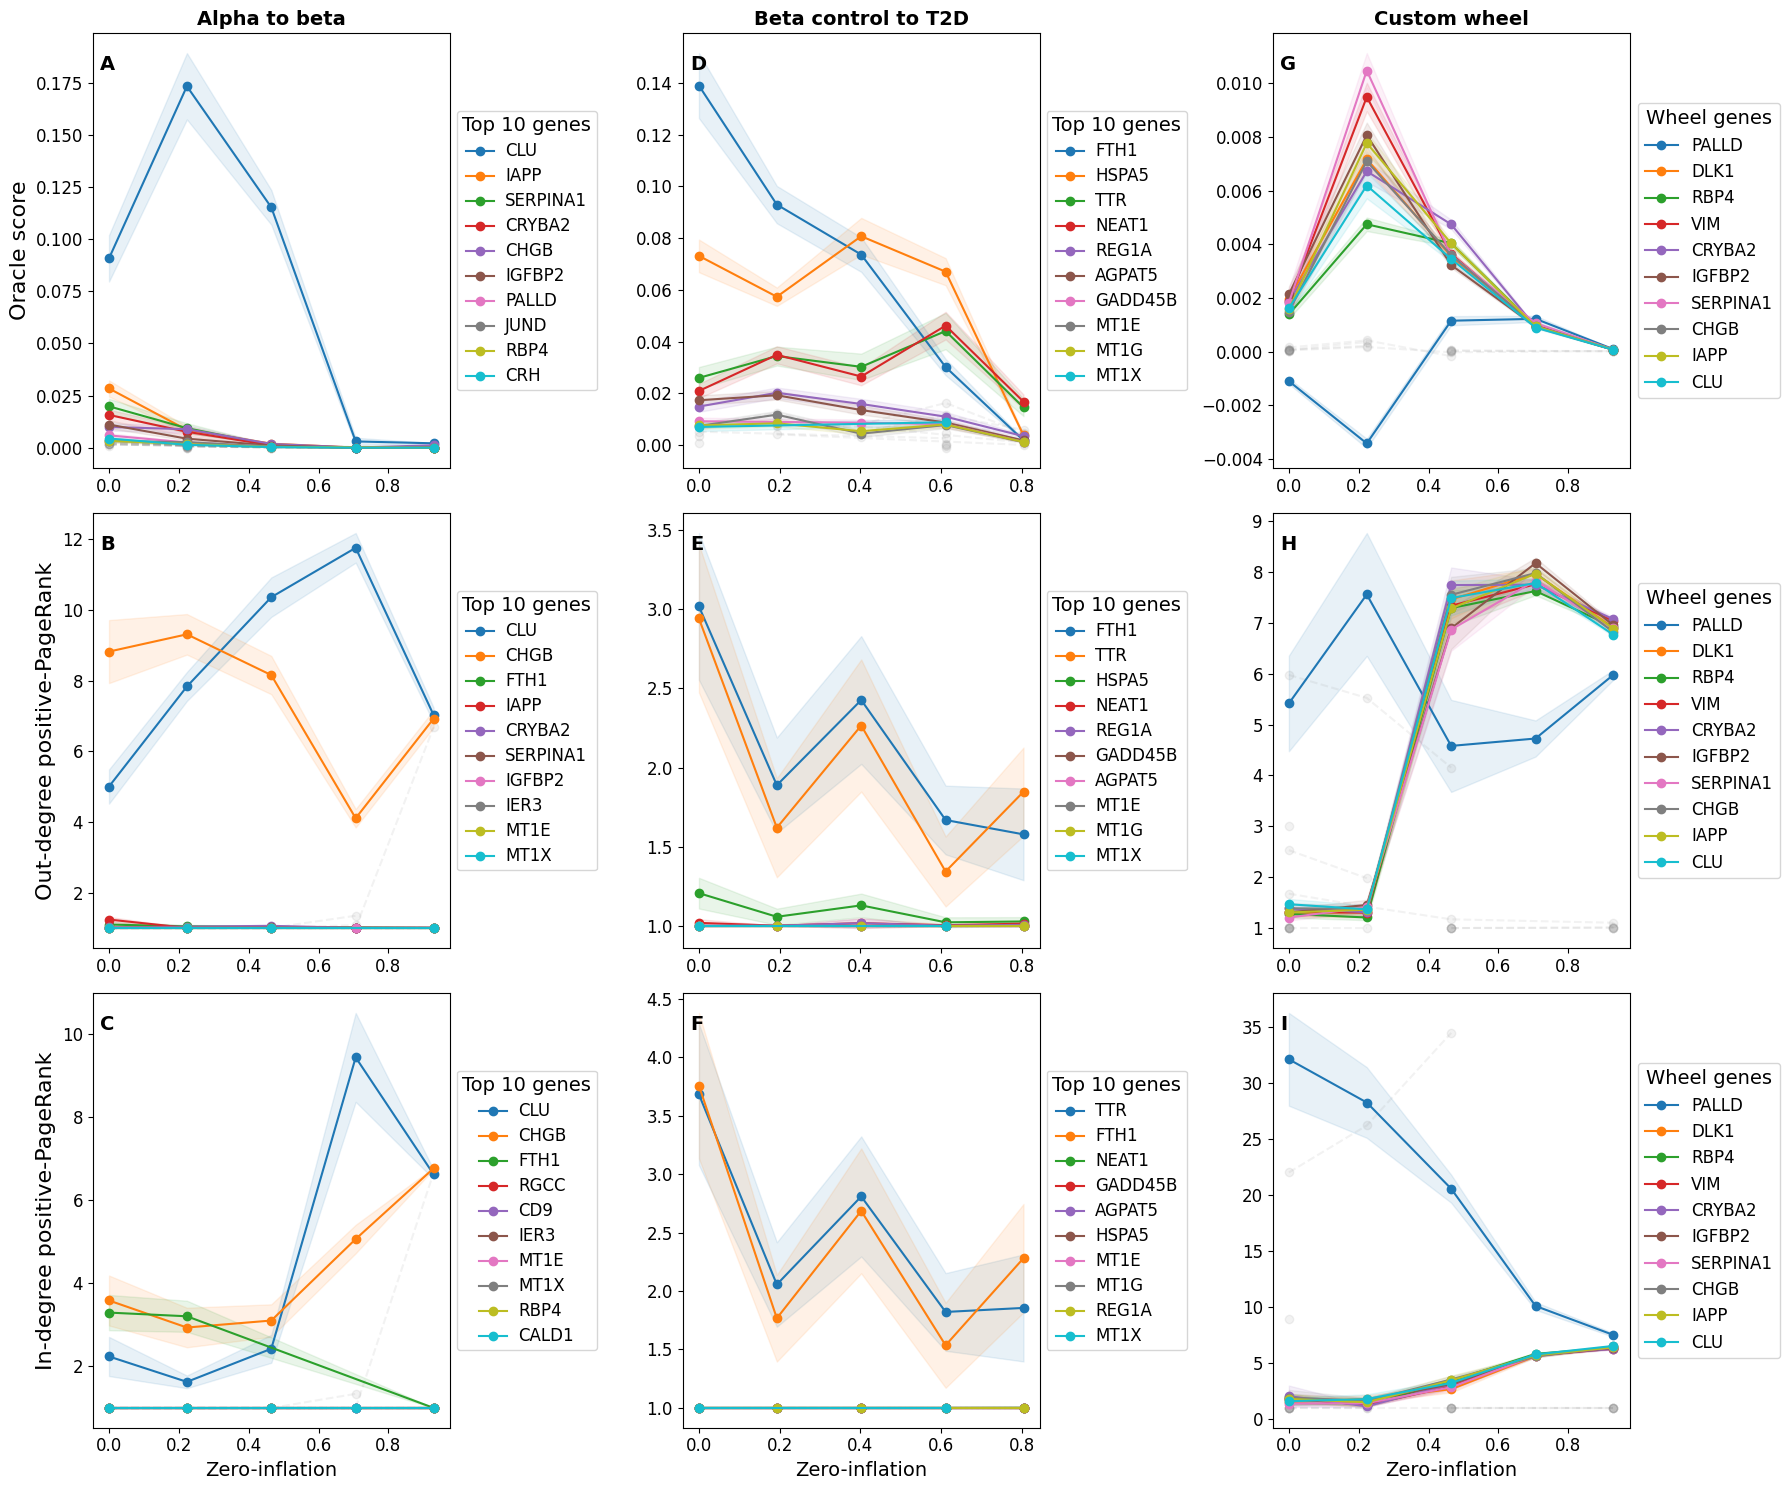

In [36]:

fig = assemble_multiplot_pval(
    dataframes=filtered_dfs, 
    score_columns=score_columns,
    label_col='label',
    zero_col='zero_inflation',
    dataset_names=['Alpha to beta', 'Beta control to T2D', 'Custom wheel'],  # Custom row labels
    score_titles=['Oracle score', 'Out-degree positive-PageRank', 'In-degree positive-PageRank'],      # Custom column titles
    x_axis_label='Zero inflation proportion'  # Custom X-axis label
)
fig.savefig(main_path+'SimulationResults_acat_fdr_filtered.png')

In [10]:
print(umapa2b['state'].value_counts())
print(umapttoc['state'].value_counts())
print(umapwheel['state'].value_counts())

state
start    4999
goal     4999
Name: count, dtype: int64
state
start    3822
goal     3821
Name: count, dtype: int64
state
start    5000
goal     5000
Name: count, dtype: int64


              start      goal
HES4       0.019612  0.019612
ISG15      0.022218  0.022218
ERRFI1     0.030904  0.030904
SPSB1      0.014266  0.014266
RBP7       0.014655  0.014655
...             ...       ...
IL13RA2    0.018242  0.018242
MOSPD1     0.014730  0.014730
LINC00632  0.012692  0.012692
BGN        0.013282  0.013282
FLNA       0.017460  0.017460

[500 rows x 2 columns]


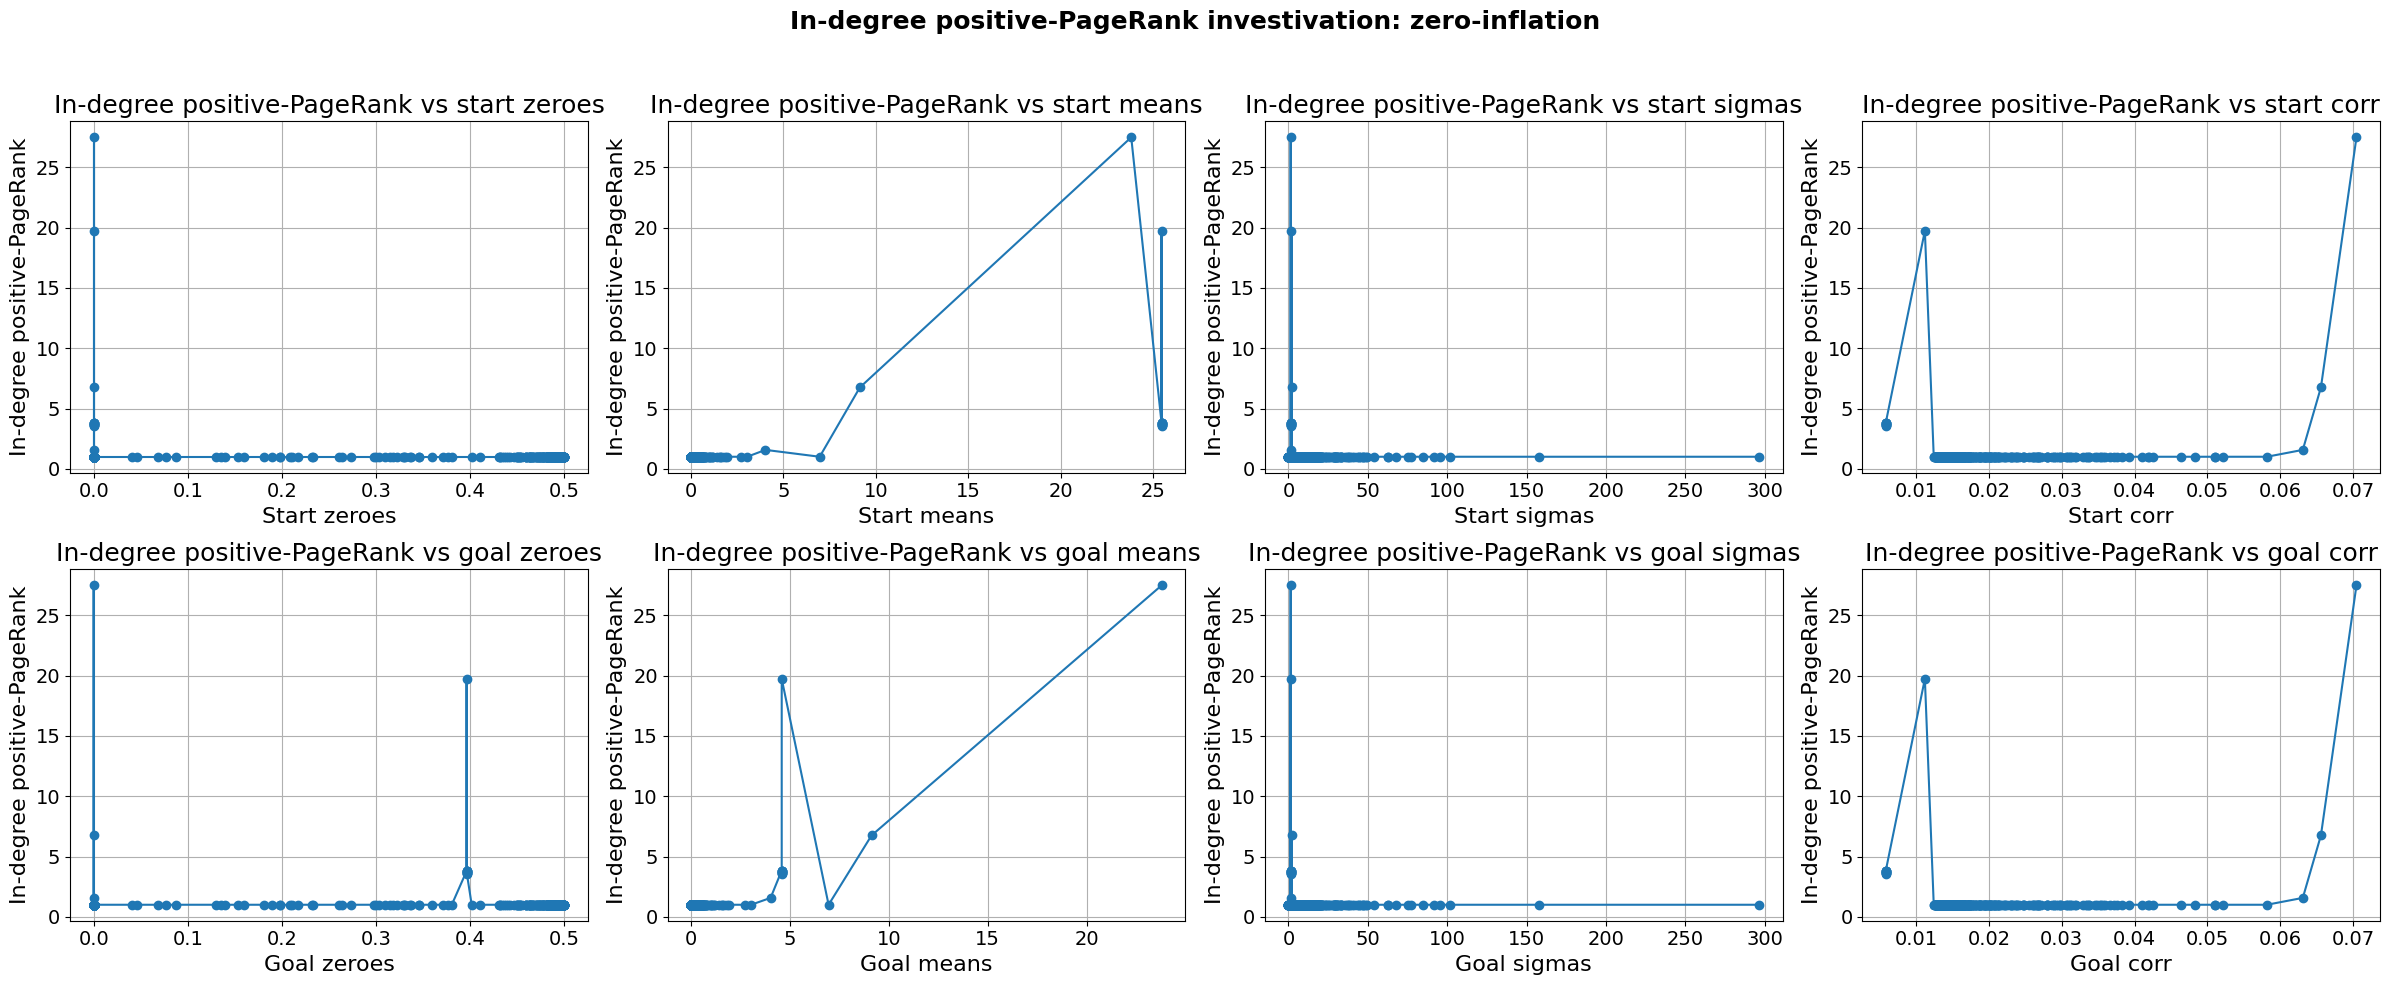

In [13]:
def plot_sorted_line(df, x, y, ax=None, title=None, xlabel=None, ylabel=None):
    """
    Plot a line graph of y vs x after sorting the DataFrame by x.
    Text sizes tuned for a 6×4″ figure in a 12 pt–font paper with 1″ margins.
    """
    sorted_df = df.sort_values(by=x)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(sorted_df[x], sorted_df[y], marker='o', linestyle='-')

    # increase font sizes
    ax.set_title(title or f"{y} vs {x}", fontsize=18)
    ax.set_xlabel(xlabel or x, fontsize=16)
    ax.set_ylabel(ylabel or y, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

    ax.grid(True)

    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax


def plot_grid_of_sorted_lines(df, x_cols, y_col, figsize=(24, 10), suptitle=None):
    """
    Plot a 2x3 grid of line plots for one y column against 6 different x columns.
    Text sizes tuned for a 6×4″ figure in a 12 pt–font paper with 1″ margins.
    """
    assert len(x_cols) == 8, "Exactly 6 x columns are required."

    fig, axes = plt.subplots(2, 4, figsize=figsize)
    axes = axes.flatten()  # make it easy to index

    for i, x in enumerate(x_cols):
        x_text=x.replace("_", " ").capitalize()
        sorted_df = df.sort_values(by=x)
        ax = axes[i]
        ax.plot(sorted_df[x], sorted_df[y_col], marker='o', linestyle='-')
        ax.set_title(f"In-degree positive-PageRank vs {x_text.lower()}", fontsize=18)
        ax.set_xlabel(x_text, fontsize=16)
        ax.set_ylabel("In-degree positive-PageRank", fontsize=16)
        ax.tick_params(axis='both', labelsize=14)
        ax.grid(True)

    if suptitle:
        fig.suptitle(suptitle, fontsize=18,fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95] if suptitle else None)
    plt.show()
    return fig



# Loading
import pandas as pd
import pickle
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/realistic_simulation_alpha_to_beta_custom/wheel_simulation_parameters.pkl', 'rb') as f:
    wheel_parameters = pickle.load(f)



row_mean_abs = {
    name: df.abs().mean(axis=1)
    for name, df in wheel_parameters['copula_list'].items()
}

row_mean_abs_df = pd.DataFrame(row_mean_abs)

print(row_mean_abs_df)
investivation_of_wheel=pd.DataFrame({
    "start_means":wheel_parameters['mean_mat'][wheel_parameters['covariate']['state']=="start"].iloc[1,:],
    "goal_means":wheel_parameters['mean_mat'][wheel_parameters['covariate']['state']=="goal"].iloc[1,:],
    "start_sigmas":wheel_parameters['sigma_mat'][wheel_parameters['covariate']['state']=="start"].iloc[1,:],
    "goal_sigmas":wheel_parameters['sigma_mat'][wheel_parameters['covariate']['state']=="goal"].iloc[1,:],
    "start_zeroes":wheel_parameters['zero_mat'][wheel_parameters['covariate']['state']=="start"].iloc[1,:],
    "goal_zeroes":wheel_parameters['zero_mat'][wheel_parameters['covariate']['state']=="goal"].iloc[1,:],
    'start_corr':row_mean_abs_df['start'],
    'goal_corr':row_mean_abs_df['goal']
             }).merge(dataframes[2].groupby(dataframes[2].index)[['in_degree_pagerank_positive','out_degree_pagerank_positive','oracle_score']].mean(),left_index=True,right_index=True).sort_values('in_degree_pagerank_positive')
in_degree_investigation_plot=plot_grid_of_sorted_lines(
    df=investivation_of_wheel,
    x_cols=['start_zeroes','start_means', 'start_sigmas', 'start_corr',  'goal_zeroes', 'goal_means', 'goal_sigmas','goal_corr'],
    y_col='in_degree_pagerank_positive',
    suptitle="In-degree positive-PageRank investivation: zero-inflation"
)

in_degree_investigation_plot.savefig('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/extreme_sigma_sensitivity.png')

In [ ]:
import pandas as pd

# assume dfs = {'start': start_df, 'goal': goal_df}

row_mean_abs = {
    name: df.abs().mean(axis=1)
    for name, df in wheel_parameters['copula_list'].items()
}

# If you want to combine them into a single DataFrame:
row_mean_abs_df = pd.DataFrame(row_mean_abs)

print(row_mean_abs_df)

In [ ]:

dataframes[2].groupby(dataframes[2].index)[['in_degree_pagerank_positive','out_degree_pagerank_positive','oracle_score']].mean()